# Cross-link 2407-dataset

The dataset has the cross-link maps per detector in $N_{\rm side}=128$ in HDF5 format.
The configration of the simulation as follows:

- Software: Falcons.jl v1.0.1
- IMo version: IMo-v2
- Sampling rate: 19 Hz
- Considered spin number $n$: 1 to 5
- No HWP
- Directory structure:
  - Channel names (22 bands)
    - Detector names (Only `Top`-detector, total number of files: 4508/2)
    - Naming rule: `{detname}.h5`
  - Boresight


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sbm
from sbm import ScanFields

# Definision of cross-link

We define the cross-link as:

$$
{}_{n}\tilde{h} = \frac{1}{N_{\rm hits}}\sum_{j}e^{-in\psi_j}
= \langle \cos(n\psi_j) \rangle + i\langle \sin(n\psi_j) \rangle
$$

where $\psi$ represents crossing angle, and $j$ represents $j^{\rm{th}}$ measurement in a sky pixel. $N_{\rm hits}$ represents number of hits in a sky pixel.

You can get the value of it by `get_xlink(data, spin_n)` with specified spin number. In the 2407-dataset, you can access spin 1 to 5.


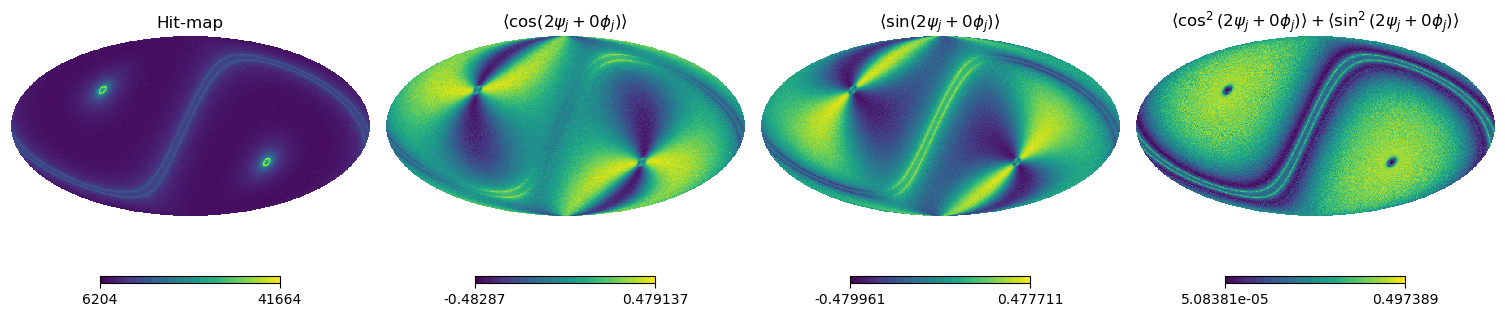

In [2]:
# Load single detector map
# It assumes that base_path has been installed to SBM by install_db()

filename1 = "L1-040/000_000_003_QA_040_T"
filename2 = "L1-040/000_004_005_UA_040_T"
sf1 = ScanFields.load_det(filename1)
sf2 = ScanFields.load_det(filename2)

spin_n = 2
spin_m = 0
C = rf"$\langle \cos({spin_n}\psi_j + {spin_m}\phi_j)\rangle$"
S = rf"$\langle \sin({spin_n}\psi_j + {spin_m}\phi_j)\rangle$"
CS = rf"$\langle \cos^2({spin_n}\psi_j + {spin_m}\phi_j)\rangle + \langle \sin^2({spin_n}\psi_j + {spin_m}\phi_j)\rangle$"
plt.figure(figsize=(15,12))
hp.mollview(sf1.hitmap, title="Hit-map", sub=(1,4,1))
hp.mollview(sf1.get_xlink(spin_n, spin_m).real, title=C, sub=(1,4,2))
hp.mollview(sf1.get_xlink(spin_n, spin_m).imag, title=S, sub=(1,4,3))
hp.mollview(np.abs(sf1.get_xlink(spin_n, spin_m)), title=CS, sub=(1,4,4))

# Scan-field operation

If you add two `Scanfield` instances, the hit-map and ${}_{n}\tilde{h}$ will be added by the special method: `__add__()`.

The hit-map is added by simple addition, and ${}_{n}\tilde{h}$ is added by weighted average:

$$
N_{\rm hits}^{\rm tot} = N_{\rm hits}^{(1)} + N_{\rm hits}^{(2)} \\
$$

$$
{}_{n}\tilde{h}^{\rm tot} = \frac{{}_{n}\tilde{h}^{(1)} N_{\rm hits}^{(1)} + {}_{n}\tilde{h}^{(2)} N_{\rm hits}^{(2)}}{N_{\rm hits}^{\rm tot}}
$$

where the number in $(.)$ represents a detector ID.


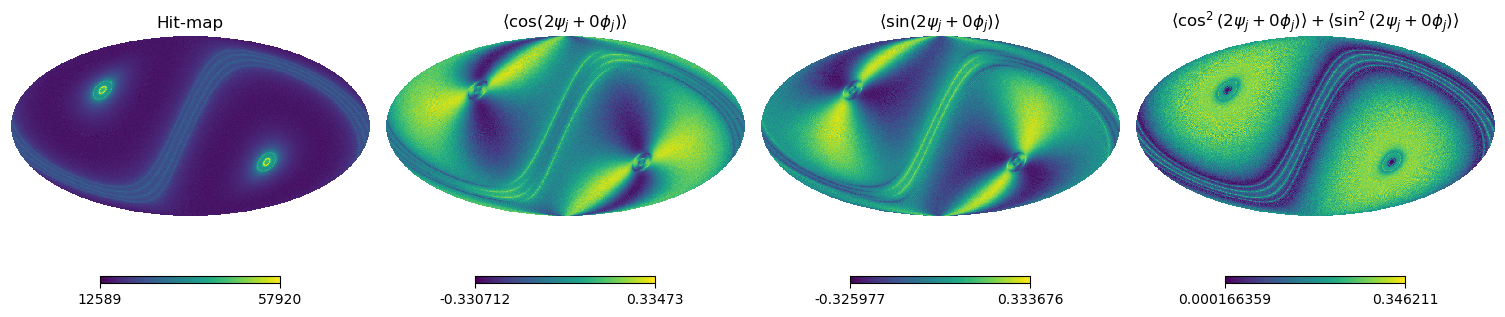

In [3]:
# add Scanfield instances
sf_sum = sf1 + sf2
spin_n = 2

plt.figure(figsize=(15,12))
hp.mollview(sf_sum.hitmap, title="Hit-map", sub=(1,4,1))
hp.mollview(sf_sum.get_xlink(spin_n, spin_m).real, title=C, sub=(1,4,2))
hp.mollview(sf_sum.get_xlink(spin_n, spin_m).imag, title=S, sub=(1,4,3))
hp.mollview(np.abs(sf_sum.get_xlink(spin_n, spin_m)), title=CS, sub=(1,4,4))

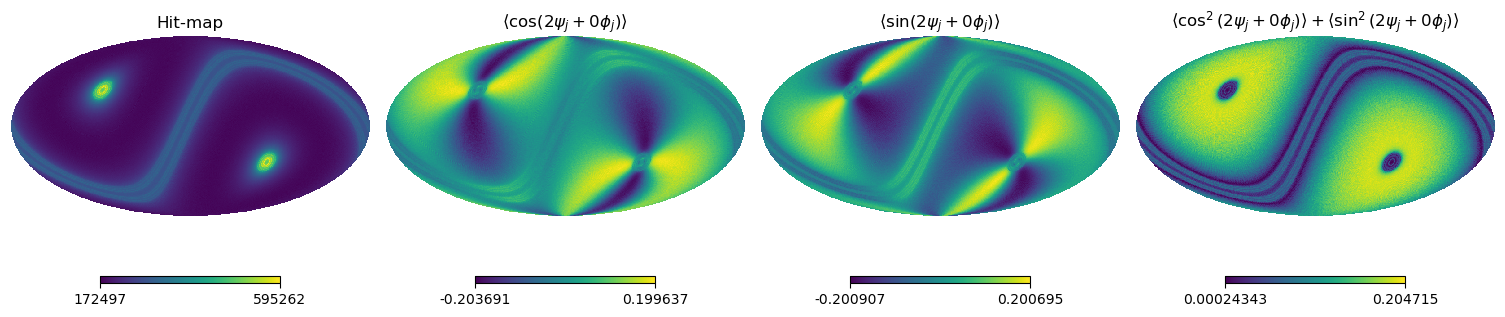

In [4]:
# Load maps per channel
# It assumes that base_path has been installed to SBM by install_db()
channel = "L1-040"
sf_ch = ScanFields.load_channel(channel)

spin_n = 2
plt.figure(figsize=(15,12))
hp.mollview(sf_ch.hitmap, title="Hit-map", sub=(1,4,1))
hp.mollview(sf_ch.get_xlink(spin_n, spin_m).real, title=C, sub=(1,4,2))
hp.mollview(sf_ch.get_xlink(spin_n, spin_m).imag, title=S, sub=(1,4,3))
hp.mollview(np.abs(sf_ch.get_xlink(spin_n, spin_m)), title=CS, sub=(1,4,4))

In [5]:
# It loads all the channels in parallel
sf_total = ScanFields.load_full_FPU(sbm.channel_list, base_path=sbm.DB_ROOT_PATH)

Using 128 processes


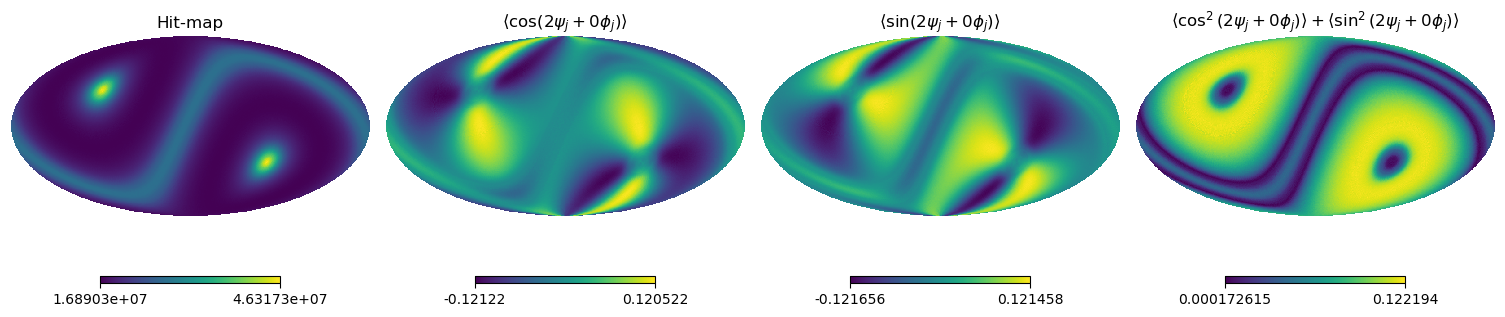

In [6]:
plt.figure(figsize=(15,12))
hp.mollview(sf_total.hitmap, title="Hit-map", sub=(1,4,1))
hp.mollview(sf_total.get_xlink(spin_n, spin_m).real, title=C, sub=(1,4,2))
hp.mollview(sf_total.get_xlink(spin_n, spin_m).imag, title=S, sub=(1,4,3))
hp.mollview(np.abs(sf_total.get_xlink(spin_n, spin_m)), title=CS, sub=(1,4,4))

## Note that few MHFT detectors cannot observe the ecliptic poles as bellow:


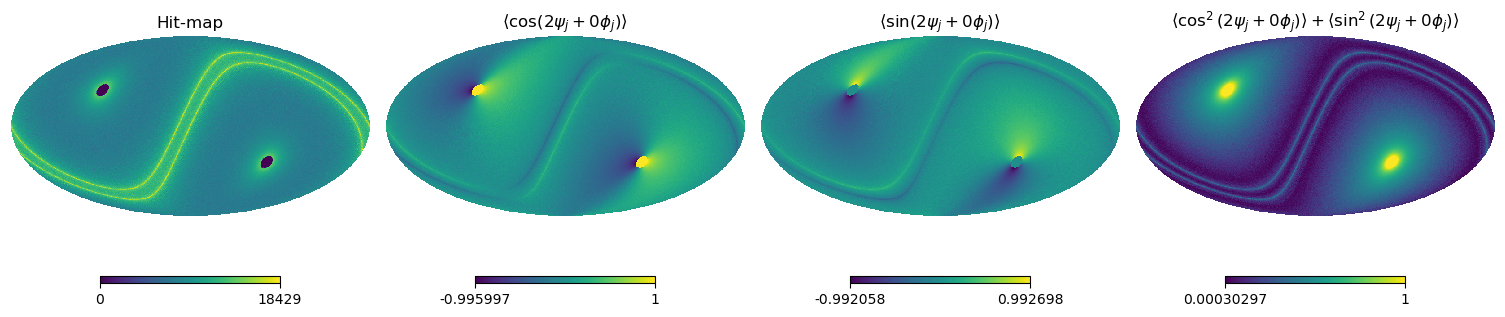

In [7]:

sf = ScanFields.load_det("002_000_000_Q_195_T", base_path=sbm.DB_ROOT_PATH+"/H1-195")

spin_n = 1
plt.figure(figsize=(15,12))
hp.mollview(sf.hitmap, title="Hit-map", sub=(1,4,1))
hp.mollview(sf.get_xlink(spin_n, spin_m).real, title=C, sub=(1,4,2))
hp.mollview(sf.get_xlink(spin_n, spin_m).imag, title=S, sub=(1,4,3))
hp.mollview(np.abs(sf.get_xlink(spin_n, spin_m)), title=CS, sub=(1,4,4))

# How to make a full-focal plane data

We generated the total scanfield as:

`sf_total = Scanfield_total(base_path, channel_list)`

However, this data is including only the top-detectors, so we must consider the bottom-detectors as well, which has 90 degrees sifted polarization angle.

So now, we can use `Scanfield` sumation and top-to-bottom comverter i.e. `.t2b()` method.

Note that `spin-2` corss-link cancels out.


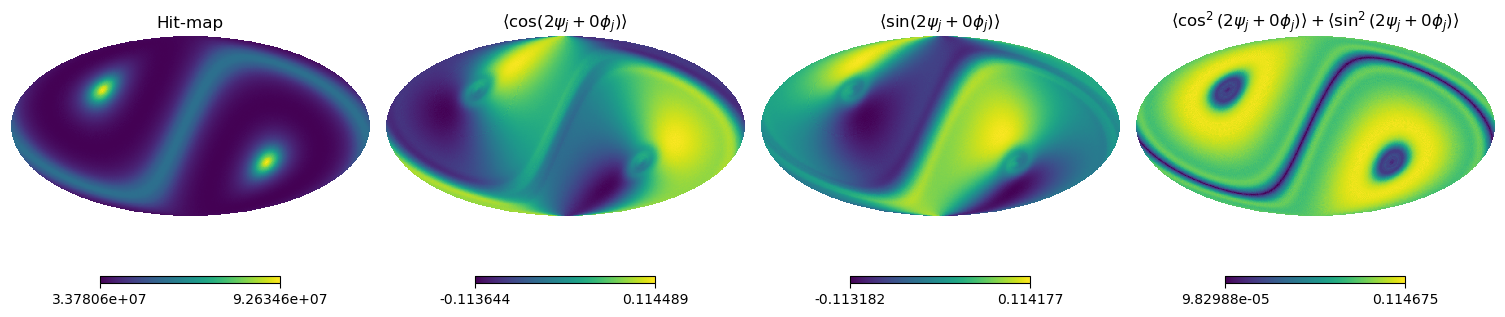

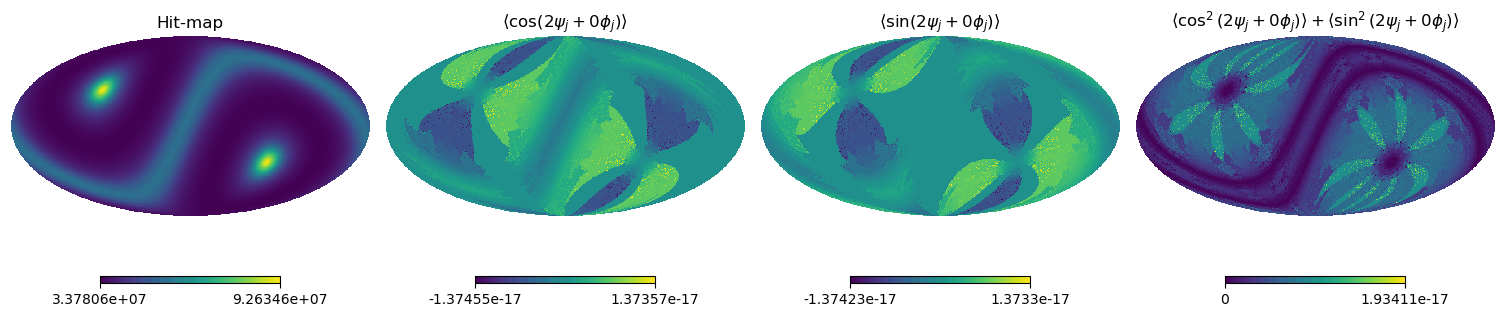

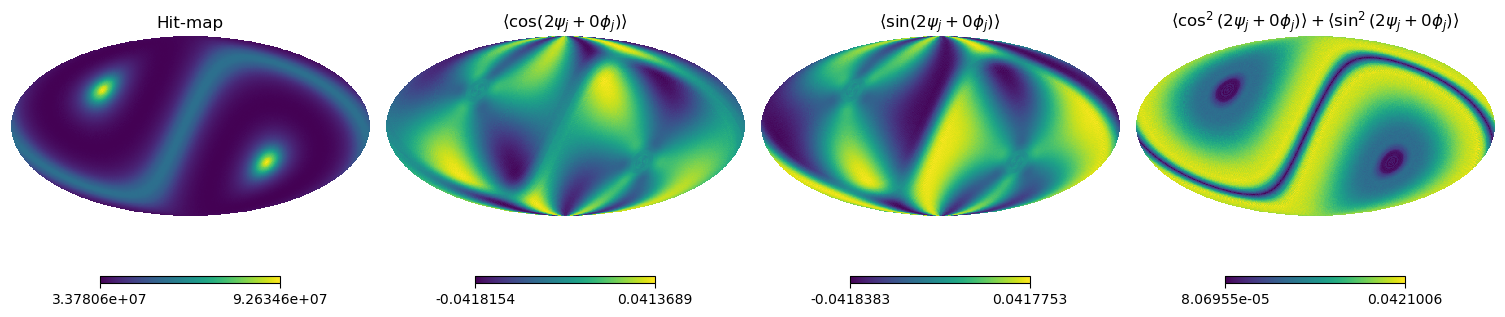

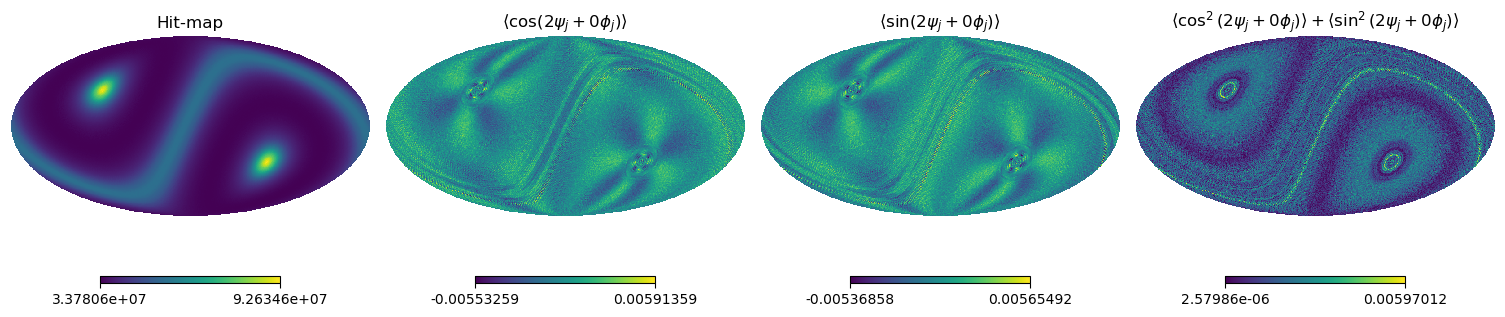

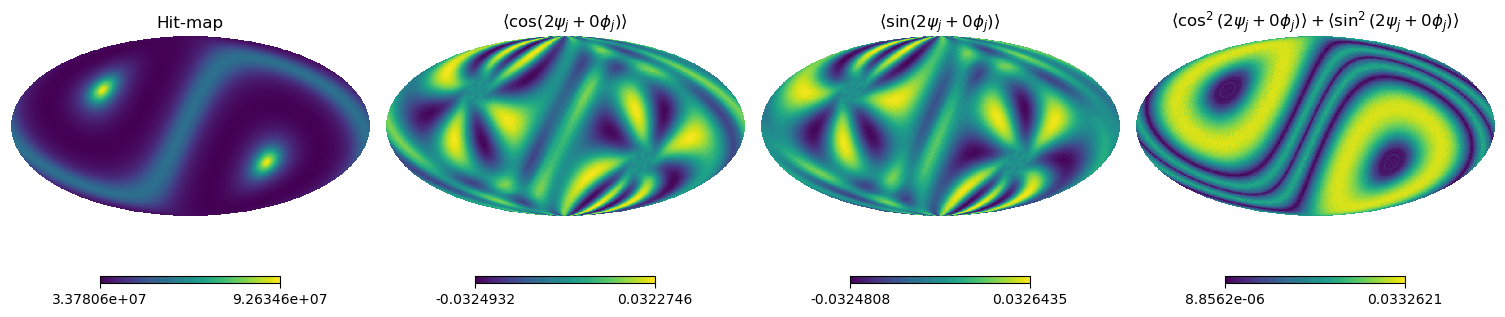

In [8]:
sf_full = sf_total + sf_total.t2b()

for spin_n in range(1,6):
    plt.figure(figsize=(15,12))
    hp.mollview(sf_full.hitmap, title="Hit-map", sub=(1,4,1))
    hp.mollview(sf_full.get_xlink(spin_n, spin_m).real, title=C, sub=(1,4,2))
    hp.mollview(sf_full.get_xlink(spin_n, spin_m).imag, title=S, sub=(1,4,3))
    hp.mollview(np.abs(sf_full.get_xlink(spin_n, spin_m)), title=CS, sub=(1,4,4))